In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import pandas as pd

data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/HW2_headlines_10000.csv")
docs = data['title']
corpus = data['title']

# if necessary, sample down the data
# docs = data.sample(n = 1000, random_state=0)['sentence'].tolist()
print(len(docs))

10000


## KMeans

In [64]:
# tfidf representation

from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')
tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
print(len(tfidf_vectorizer.vocabulary_))

5069


In [65]:
from sklearn.cluster import KMeans

K = 10
tfidf_model = KMeans(n_clusters = K, random_state = 2022)
tfidf_model.fit(tfidf)
labels = tfidf_model.labels_.tolist() 

In [66]:
#  print cluster sizes
def print_cluster_sizes(model):
  cnt_perCluster = {}
  for c in model.labels_:
    cnt_perCluster[c] = cnt_perCluster.get(c, 0) + 1
  print(cnt_perCluster)

In [67]:
print_cluster_sizes(tfidf_model)

{0: 616, 5: 812, 2: 4322, 4: 781, 8: 304, 7: 1024, 6: 919, 3: 334, 9: 580, 1: 308}


In [68]:
# print documents closest to each centroid
# sometimes we see a doc from another cluster j ends up in the list of the closest to centroid i
# this can happen when two clusters share some characteristics, 
# e.g. cluster i is about hanging out with friend, cluster j is about entertainment, a doc about going to movie with friends may be close to both centroids

import numpy as np
def print_docs_closest_to_centroids(model, vec, n):
  K = len(model.cluster_centers_)
  for j in range(K):
    d = model.transform(vec)[:, j] # transform all docs to cluster-distance space
    idx = np.argsort(d)[:n] # find n docs closest to centroid

    c_idx = [m for m, label in enumerate(model.labels_) if label==j]  # find the index of all docs in cluster j   
    print('\n\n======cluster #', j, ', cluster size:', len(c_idx))
    for i in idx:
      if i not in c_idx:
        print('[ this doc is in a different cluster #', model.labels_[i], '>>', corpus[i])
      else:
        print(corpus[i])
  return

In [69]:
print_docs_closest_to_centroids(tfidf_model, tfidf, 5)



======cluster # 0 , cluster size: 616
[ this doc is in a different cluster # 2 >> When you always gotta go...
[ this doc is in a different cluster # 2 >> Lollipop or edible?
[ this doc is in a different cluster # 2 >> Also in the May 27 JNCI
[ this doc is in a different cluster # 2 >> Who are you kidding?
Quarantine on cruise ship resulted in more Corona patients


======cluster # 1 , cluster size: 308
[ this doc is in a different cluster # 2 >> When you always gotta go...
[ this doc is in a different cluster # 2 >> Also in the May 27 JNCI
[ this doc is in a different cluster # 2 >> Lollipop or edible?
[ this doc is in a different cluster # 2 >> Who are you kidding?
E-cig use increases risk of beginning tobacco cigarette use in young adults


======cluster # 2 , cluster size: 4322
Who are you kidding?
Lollipop or edible?
Also in the May 27 JNCI
When you always gotta go...
[ this doc is in a different cluster # 9 >> Diabetes before or during pregnancy linked to early heart disease in 

In [70]:
# Plot the inertia graph
import matplotlib.pyplot as plt
def plot_inertia(inertia_list):
  plt.plot(range(1,len(inertia_list) + 1), inertia_list, 'bx-')
  plt.xlabel('Values of K')
  plt.ylabel('Inertia')
  plt.title('The Elbow Method using Inertia')
  plt.show()

In [71]:
# use the Elbow method to determine the best k
# sometimes it does not work
def elbow(m, corpus):
  inertia_lst = []
  for i in range(1, m + 1):
    model = KMeans(n_clusters = i)
    model.fit(corpus)
    
    inertia = model.inertia_
    inertia_lst.append(inertia)
  plot_inertia(inertia_lst)

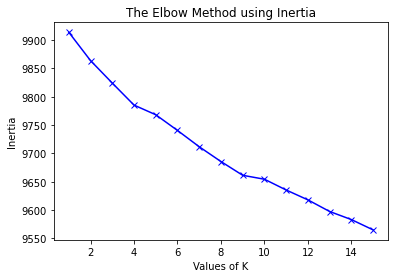

In [72]:
elbow(15, tfidf)

In [73]:
# compared to SBERT

In [74]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [76]:
sbert_embeddings = embedder.encode(corpus)

In [77]:
K = 9  # change number of cluster if applicable
sbert_model = KMeans(n_clusters = K, random_state = 2022)
sbert_model.fit(sbert_embeddings)
labels = sbert_model.labels_.tolist()  # Save cluster labels in a separate list

In [78]:
print_cluster_sizes(sbert_model)

{4: 1375, 6: 1055, 1: 1112, 8: 562, 5: 1246, 3: 849, 0: 1636, 7: 976, 2: 1189}


In [79]:
print_docs_closest_to_centroids(sbert_model, sbert_embeddings, 10)



======cluster # 0 , cluster size: 1636
Surgical patients more likely to follow medication instructions
Having a doctor who shares the race of their patients may ease pain
Think the system for paying US doctors is rigged to favor surgeons? Study may surprise you
Group doctor visits may improve life for people with muscle disorders
Mayo Clinic study finds standardized protocol and surgery improve mortality outcomes
'Pop drop' study finds more ER visits & higher costs for older disabled patients
Mass. General study examines how patient's unmet needs impact their health and health care
Study of 10 other hospitals found no reduction in adverse medical events over 6 years
Helping patients prep mind and body for surgery pays off, study suggests
Surgery patients in lower income countries have three times greater risk of dying


======cluster # 1 , cluster size: 1112
Depression treatment can prevent adolescent drug abuse
Study shows childhood psychiatric disorders increase risk for later adul

## LDA

In [3]:
# https://github.com/MaartenGr/BERTopic
# https://stackoverflow.com/questions/73830225/init-got-an-unexpected-keyword-argument-cachedir-when-importing-top2vec
# https://arxiv.org/pdf/2203.05794.pdf

#!pip install bertopic[flair, gensim, spacy, use]

!pip install bertopic
!pip install --upgrade joblib==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 8.0 MB/s 
     |████████████████████████████████| 88 kB 7.9 MB/s 
     |████████████████████████████████| 636 kB 50.4 MB/s 
     |████████████████████████████████| 5.2 MB 49.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 85 kB 5.2 MB/s 
     |████████████████████████████████| 5.5 MB 61.8 MB/s 
     |████████████████████████████████| 1.3 MB 61.7 MB/s 
     |████████████████████████████████| 163 kB 73.8 MB/s 
     |████████████████████████████████| 7.6 MB 57.0 MB/s 
     |████████████████████████████████| 1.1 MB 60.3 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp37-cp37m-linux_x86_64.whl size=2340721 sha256=13f5be000c87f53946dea5218c3497e4ca626d08763182c62d853467e1d917ba
  Stored in directory: /root/.cache

In [5]:
#from sklearn.datasets import fetch_20newsgroups
#docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

In [7]:
#LDA

# removing stopwords usually improve topic models
# stoplist is often customized to include more domain-specific topic words

from sklearn.feature_extraction import text

added_stopwords = frozenset(['just', 'did'])
my_stopwords = text.ENGLISH_STOP_WORDS.union(added_stopwords)
print(len(my_stopwords))
print(my_stopwords)

320
frozenset({'us', 'will', 'most', 'there', 'else', 'fifty', 'whom', 'six', 'many', 'i', 'ten', 'the', 'would', 'up', 'fire', 'had', 'others', 'not', 'therein', 'eg', 'neither', 'latterly', 'myself', 'as', 'over', 'through', 'perhaps', 'again', 'by', 'eleven', 'into', 'become', 'being', 'sincere', 'do', 'nevertheless', 'rather', 'while', 'get', 'across', 'hasnt', 'toward', 'inc', 'take', 'found', 'co', 'her', 'than', 'therefore', 'eight', 'another', 'during', 'whoever', 'next', 'whenever', 'from', 'besides', 'thru', 'became', 'which', 'beforehand', 'five', 'its', 'four', 'two', 'above', 'afterwards', 'beside', 'go', 'amongst', 'sometime', 'detail', 'everything', 'full', 'whither', 'a', 'you', 'our', 'been', 'here', 'mostly', 'on', 'whatever', 'whole', 'empty', 'whose', 're', 'part', 'made', 'give', 'last', 'onto', 'whence', 'how', 'hereby', 'yet', 'done', 'seemed', 'further', 'each', 'wherever', 'fifteen', 'show', 'nor', 'once', 'twenty', 'be', 'whereby', 'already', 'their', 'anyhow'

In [8]:
# tfidf usually help improve topic models

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = my_stopwords)
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
print(len(tfidf_vectorizer.vocabulary_))

5067


In [9]:
# call the LDA algorithm to fit a topic model, and transform all documents to their topic distrinbutions

from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 15

# Run NMF
# nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components = no_topics, max_iter = 10, learning_method = 'online', learning_offset = 50., random_state = 2022)
lda_z = lda.fit_transform(tfidf)

In [10]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10

In [11]:
# now examine each topic cluster to see if it makes sense
# try to label each topic cluster with a word or phrase
# it happens quite often that some topic clusters don't make sense
# when that happens, adjust the number of topics to see if better models can be created
# you can also adjust the stoplist to see if adding more stopwords leads to clearer topics

display_topics(lda, tfidf_feature_names, no_top_words)

Topic 0:
impairment testosterone wide healing fracture postmenopausal seizures plant compared fever
Topic 1:
rise study provides care uk epidemic programs health hiv new
Topic 2:
risk linked increased disease associated heart death lower women higher
Topic 3:
activity physical air pollution making data technology aging delirium syndrome
Topic 4:
arthritis rheumatoid support study health live tobacco school condition population
Topic 5:
cardiac patients approach care dialysis good improve transplant children management
Topic 6:
cancer study risk patients new disease heart treatment breast shows
Topic 7:
sexual inflammatory metabolic addiction syndrome getting mechanism researchers environment sinai
Topic 8:
testing diagnose imaging allergy marker precision physicians breakthrough financial assess
Topic 9:
cervical fibrillation atrial artificial case hemorrhage migraine pancreas postpartum degeneration
Topic 10:
mothers resistance don bad insulin aortic highlights valve antidepressants b

In [12]:
# now examine the topic distribution in each document
# since each document is considered a mixture of all topics with different probabilities

# lda_z stores the prob distribution for each document
# for the 20newsgroup dataset, it is a 11314*15 matrix
# 11314 documents, 15 topics

# examine document #5 (index starts at 0)
# high prob for topics #6 and #7 (index starts at 0), with probs 0.40 and 0.41
# the document reads as related to religion

print(lda_z.shape)
print(lda_z[5])
print(docs[5])
#print(documents.shape)

(10000, 15)
[0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]
Also in the May 27 JNCI


In [13]:
# import bertopic

FileNotFoundError: ignored

In [14]:
# notes from BERTopic documentation
# We start by instantiating BERTopic. We set language to english since our documents are in the English language. 
# If you would like to use a multi-lingual model, please use language="multilingual" instead.
# Use language="multilingual" to select a model that support 50+ languages.
# 
# We will also calculate the topic probabilities. 
# However, this can slow down BERTopic significantly at large amounts of data (>100_000 documents). 
# It is advised to turn this off if you want to speed up the model.
#
# select sentence transformer models from https://www.sbert.net/docs/pretrained_models.html
# The all-* models where trained on all available training data (more than 1 billion training pairs) and are designed as general purpose models. 
# The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality.

from bertopic import BERTopic

topic_model = BERTopic(embedding_model = "all-MiniLM-L12-v2", calculate_probabilities = True, verbose = True)
topics, probs = topic_model.fit_transform(docs)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/573 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/352 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2022-11-09 01:45:21,661 - BERTopic - Transformed documents to Embeddings
2022-11-09 01:46:08,555 - BERTopic - Reduced dimensionality
2022-11-09 01:46:20,271 - BERTopic - Clustered reduced embeddings


In [25]:
# topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2022-11-09 01:57:08,331 - BERTopic - Transformed documents to Embeddings
2022-11-09 01:57:32,524 - BERTopic - Reduced dimensionality
2022-11-09 01:57:44,468 - BERTopic - Clustered reduced embeddings


In [15]:
# After generating topics and their probabilities, we can access the frequent topics that were generated
# -1 refers to all outliers and should typically be ignored. 

freq = topic_model.get_topic_info(); 
num_topics = len(freq) - 1
print(num_topics)
freq.head(num_topics)

198


,Topic,Count,Name
0,-1,2656,-1_breast_to_in_health
1,0,251,0_dementia_alzheimer_cognitive_memory
2,1,223,1_preterm_birth_babies_births
3,2,198,2_diabetes_type_insulin_glucose
4,3,149,3_tobacco_smoking_cigarettes_quit
...,...,...,...
193,192,11,192_pollution_air_exposure_birth
194,193,11,193_body_shape_index_influences
195,194,11,194_rebuilding_compression_pumps_entire
196,195,11,195_obesity_bmi_adiponectin_carcinogenesis


In [16]:
for i in range(num_topics):
  print("\n== Representative documents in cluster #", i)
  print(topic_model.get_representative_docs(i))


== Representative documents in cluster # 0
['Frequent sauna bathing protects men against dementia', 'Holistic approach to mealtimes could help dementia sufferers', 'Diabetes duration and severity associated with brain atrophy']

== Representative documents in cluster # 1
['Birth and pregnancy experts fail to deliver on contraception advice', 'Inducing labor at 39 weeks may benefit pregnant women and their babies', 'Device-assisted feeding and poor growth in newborns with CHD may lead to poor neurodevelopment']

== Representative documents in cluster # 2
['Automatic suspension of insulin delivery via insulin pumps reduces hypoglycemia', 'New pathway to cheap insulin', 'Home use of hybrid closed-loop insulin delivery system shown safe and effective']

== Representative documents in cluster # 3
['Study reveals impact of plain cigarette packaging warnings', 'Study: E-cigarette online vendors triple, concerns raised about marketing, delivery', 'Much of the increased risk of death from smok

In [17]:
topic_model.find_topics("work")

([140, 122, 132, 176, 148],
 [0.8173087959430541,
  0.5434155005460877,
  0.5167521912665454,
  0.4903345560414054,
  0.48642907598105806])

In [18]:
topic_model.get_topic(0)  # Select the most frequent topic

[('dementia', 0.06404893733470493),
 ('alzheimer', 0.0558955720225064),
 ('cognitive', 0.032911173973464145),
 ('memory', 0.024689361002223104),
 ('decline', 0.0219094820068382),
 ('impairment', 0.011599537353576725),
 ('disease', 0.011575512236384833),
 ('brain', 0.010187676990152383),
 ('people', 0.009745638204987833),
 ('aging', 0.009704172114072075)]

In [83]:
topic_model.visualize_topics()

In [82]:
topic_model.visualize_distribution(probs[200], min_probability = 0.010)

In [24]:
topic_model.visualize_hierarchy(top_n_topics = 50)

In [22]:
topic_model.visualize_barchart(top_n_topics = 10)

In [23]:
topic_model.visualize_heatmap(n_clusters = 10, width = 1000, height = 1000)